# InterestBasic

Author: Yuteng Huang (2025)

Note: This version should be a runnable version.

## Preparation

Install the packages:

```
pip install pandas numpy scikit-learn gensim keras nltk tensorflow matplotlib
```

Ensure your directory structure:

```
/
- this_notebook.ipynb
- /data/
  - labels.txt
  - papers.txt
  - training.txt
  - validation.txt
```


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

print("Import successful!")

Import successful!


In [2]:
def load_training_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f if line.strip()]

    authors = []
    interests = []
    for i in range(0, len(lines), 2):
        authors.append(lines[i])
        interests.append(lines[i+1].split(","))

    return pd.DataFrame({
        "author": authors,
        "interests": interests
    })

# 加载数据
train_df = load_training_data("data/training.txt")
print(f"训练数据加载完成，共 {len(train_df)} 个样本")
print(f"前3个样本:\n{train_df.head(3)}")

训练数据加载完成，共 6000 个样本
前3个样本:
                           author  \
0               Daniel J. Paulish   
1  José Cristóbal Riquelme Santos   
2          Fernando C. N. Pereira   

                                           interests  
0  [software engineering, software architecture, ...  
1  [neural networks, machine learning, evolutiona...  
2  [computer science, natural language processing...  


In [3]:
# 单元格3：加载论文数据并进行特殊处理
def enhanced_load_papers_data(file_path, max_papers=None):
    papers = []

    with open(file_path, "r", encoding="utf-8") as f:
        current_paper = {}
        for line in f:
            line = line.strip()
            if line.startswith("#index"):
                if current_paper:
                    papers.append(current_paper)
                current_paper = {
                    "index": line[6:],
                    "authors": "",
                    "title": "",
                    "year": "",
                    "venue": "",
                    "citations": []
                }
            elif line.startswith("#@"):
                current_paper["authors"] = line[2:]
            elif line.startswith("#*"):
                current_paper["title"] = line[2:]
            elif line.startswith("#t"):
                current_paper["year"] = line[2:]
            elif line.startswith("#c"):
                current_paper["venue"] = line[2:]
            elif line.startswith("#%"):
                current_paper["citations"].append(line[2:])
            else:
                if current_paper:
                    papers.append(current_paper)
                    current_paper = {}
                if len(papers) >= max_papers:
                    break

    df_papers = pd.DataFrame(papers)

    # 原代码的特殊处理：期刊名作为一个单词
    def remove_space(x):
        return x.replace(" ", "") if isinstance(x, str) else ""

    df_papers["jour_"] = df_papers["venue"].apply(remove_space)
    df_papers["jour_paper"] = (
        df_papers["venue"] + " " +
        df_papers["title"] + " " +
        df_papers["jour_"]
    )

    return df_papers

# 加载论文数据
papers_df = enhanced_load_papers_data("data/papers.txt", max_papers=500000)
print(f"论文数据加载完成，共 {len(papers_df)} 篇论文")
print(f"论文数据结构: {papers_df.shape}")
print(f"前3篇论文信息:\n{papers_df[['authors', 'title']].head(3)}")

论文数据加载完成，共 500000 篇论文
论文数据结构: (500000, 8)
前3篇论文信息:
                                             authors  \
0                      Sinjini Mitra,Marios Savvides   
1  Alberto Villa,Jocelyn Chanussot,Jon Atli Bened...   
2        Tingyuan Nie,Tomoo Kisaka,Masahiko Toyonaga   

                                               title  
0  Improved Human Face Identification Using Frequ...  
1  Unsupervised methods for the classification of...  
2  A post layout watermarking method for IP prote...  


In [4]:
import re

# 单元格4：文本预处理函数
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = ' '.join(text.split())
    return text

# 应用文本预处理
papers_df["processed_text"] = papers_df["jour_paper"].apply(preprocess_text)
print("文本预处理完成")
print(f"预处理示例:\n原始: {papers_df['jour_paper'].iloc[0][:100]}...")
print(f"处理后: {papers_df['processed_text'].iloc[0][:100]}...")

文本预处理完成
预处理示例:
原始: ICASSP (2) Improved Human Face Identification Using Frequency Domain Representation of Facial Asymme...
处理后: icassp improved human face identification using frequency domain representation of facial asymmetry ...


In [5]:
# 单元格5：构建作者特征（包含作者位置权重）
def build_author_features_enhanced(papers_df, all_authors):
    author_papers = defaultdict(list)
    author_weights = defaultdict(list)
    author_citations = defaultdict(list)
    citation_weights = defaultdict(list)

    # 处理多作者位置
    papers_df["authors_list"] = papers_df["authors"].apply(
        lambda x: [a.strip() for a in x.split(",")] if isinstance(x, str) else []
    )

    # 构建作者论文特征
    print("正在构建作者论文特征...")
    for idx, paper in papers_df.iterrows():
        authors = paper["authors_list"]
        paper_content = paper["processed_text"]

        if paper_content:
            for i, author in enumerate(authors):
                if author and author in all_authors:
                    weight = (1 - 0.05 * i) if i < 10 else 0.5
                    author_papers[author].append(paper_content)
                    author_weights[author].append(weight)

    # 构建引用索引
    citation_index = {}
    for idx, paper in papers_df.iterrows():
        citation_index[paper["index"]] = idx

    # 处理引用论文特征
    print("正在构建引用论文特征...")
    for idx, paper in papers_df.iterrows():
        for citation in paper["citations"]:
            if citation in citation_index:
                cited_paper_idx = citation_index[citation]
                cited_paper_content = papers_df.iloc[cited_paper_idx]["processed_text"]

                if cited_paper_content:
                    authors = paper["authors_list"]
                    for i, author in enumerate(authors[:5]):  # 只处理前5个作者
                        if author and author in all_authors:
                            weight = (1 - i * 0.1) * 0.5
                            author_citations[author].append(cited_paper_content)
                            citation_weights[author].append(weight)

    return author_papers, author_weights, author_citations, citation_weights

# 加载验证数据
with open("data/validation.txt", "r", encoding="utf-8") as f:
    validation_authors = [line.strip() for line in f if line.strip()]

# 合并所有作者
all_authors = train_df['author'].tolist() + validation_authors

# 构建特征
author_papers, author_weights, author_citations, citation_weights = build_author_features_enhanced(papers_df, all_authors)

print(f"找到 {len(author_papers)} 个有论文的作者")

正在构建作者论文特征...
正在构建引用论文特征...
找到 9458 个有论文的作者


In [6]:
# 单元格6：构建TF-IDF特征矩阵
def build_tfidf_features_enhanced(author_papers, author_weights, author_citations, citation_weights, authors_list, vectorizer=None):
    documents = []

    for author in authors_list:
        # 合并作者自己的论文和引用的论文
        papers = author_papers.get(author, [])
        citations = author_citations.get(author, [])
        all_docs = papers + citations

        if all_docs:
            combined_doc = ' '.join(all_docs)
            documents.append(combined_doc)
        else:
            documents.append("")  # 没有论文的作者

    # TF-IDF转换
    if vectorizer is None:
        vectorizer = TfidfVectorizer(
            max_features=2048,
            min_df=16,
            max_df=0.8,
            stop_words='english',
            ngram_range=(1, 2)
        )
        tfidf_matrix = vectorizer.fit_transform(documents)
    else:
        tfidf_matrix = vectorizer.transform(documents)

    return tfidf_matrix, vectorizer

# 先构建训练特征并获取vectorizer
print("构建训练特征...")
X_train, vectorizer = build_tfidf_features_enhanced(
    author_papers, author_weights, author_citations, citation_weights,
    train_df['author'].tolist()
)

print(f"训练特征矩阵形状: {X_train.shape}")

# 使用相同的vectorizer构建验证特征
print("构建验证特征...")
X_val, _ = build_tfidf_features_enhanced(
    author_papers, author_weights, author_citations, citation_weights,
    validation_authors,
    vectorizer=vectorizer  # 使用训练集的vectorizer
)

print("TF-IDF特征构建完成")
print(f"训练特征矩阵形状: {X_train.shape}")
print(f"验证特征矩阵形状: {X_val.shape}")

# 验证维度一致性
if X_train.shape[1] == X_val.shape[1]:
    print("特征维度一致")
else:
    print("特征维度不一致")

构建训练特征...
训练特征矩阵形状: (6000, 2048)
构建验证特征...
TF-IDF特征构建完成
训练特征矩阵形状: (6000, 2048)
验证特征矩阵形状: (4000, 2048)
特征维度一致


In [7]:
# 单元格7：创建软标签目标变量
def create_soft_labels(train_df, all_labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)

    num_authors = len(train_df)
    num_labels = len(all_labels)

    # 初始化所有标签为0.05
    y_matrix = 0.05 * np.ones((num_authors, num_labels))

    for idx, row in train_df.iterrows():
        interests = row['interests']
        for interest_idx, interest in enumerate(interests):
            if interest in label_encoder.classes_:
                label_idx = label_encoder.transform([interest])[0]
                score = 1.0 - 0.1 * interest_idx
                y_matrix[idx, label_idx] = score

    return y_matrix, label_encoder

# 加载标签数据
with open("data/labels.txt", "r", encoding="utf-8") as f:
    all_labels = [line.strip() for line in f if line.strip()]

# 创建软标签
y_train, label_encoder = create_soft_labels(train_df, all_labels)

print(f"目标变量形状: {y_train.shape}")
print(f"标签数量: {len(all_labels)}")
print(f"示例目标向量（前100个值）: {y_train[0, :100]}")

目标变量形状: (6000, 789)
标签数量: 789
示例目标向量（前100个值）: [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05]


In [8]:
# 单元格8：训练模型（修复后）
def create_model(input_dim, output_dim):
    model = Sequential([
        Dense(2048, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.002),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print(f"创建模型...")
model = create_model(X_train.shape[1], y_train.shape[1])

print("训练模型...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

print("模型训练完成")
print(f"最终训练准确率: {history.history['accuracy'][-1]:.4f}")
print(f"最终验证准确率: {history.history['val_accuracy'][-1]:.4f}")

创建模型...
训练模型...
Epoch 1/20


d:\Repos\USTB-Term-Projects\PythonProgramming\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.0817 - loss: 0.3831 - val_accuracy: 0.0550 - val_loss: 0.2079
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1729 - loss: 0.2186 - val_accuracy: 0.0917 - val_loss: 0.2075
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1929 - loss: 0.2135 - val_accuracy: 0.1708 - val_loss: 0.2072
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1975 - loss: 0.2119 - val_accuracy: 0.1775 - val_loss: 0.2072
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2081 - loss: 0.2107 - val_accuracy: 0.2042 - val_loss: 0.2074
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2146 - loss: 0.2099 - val_accuracy: 0.1900 - val_loss: 0.2074
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2208 - loss: 0.2098 - val_accuracy: 0.1992 - val_loss: 0.2078
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2229 - loss: 0.2094 - val_accuracy: 0.199

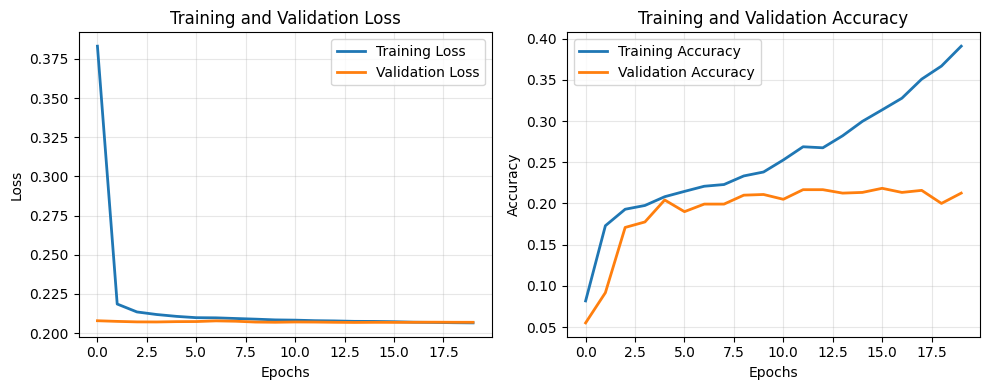

In [9]:
# 单元格9：绘制训练过程可视化
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [10]:
# 单元格10：加载验证答案并计算准确率
def load_validation_truth(file_path):
    truth_data = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split("\t")
                if len(parts) >= 4:
                    author = parts[0]
                    interests = parts[1:4]  # 取前3个兴趣
                    truth_data[author] = interests
    return truth_data

def predict_top_interests(model, X, label_encoder, top_k=5):
    if hasattr(X, 'toarray'):
        X_dense = X.toarray()
    else:
        X_dense = X

    predictions = model.predict(X_dense, verbose=0)
    results = []

    for pred in predictions:
        top_indices = np.argsort(pred)[-top_k:][::-1]
        top_labels = label_encoder.inverse_transform(top_indices)
        results.append(top_labels)

    return results

def calculate_metrics(validation_authors, predictions, truth_data):
    top1_correct = [0, 0, 0]
    top5_correct = [0, 0, 0]
    processed_samples = 0

    for i, author in enumerate(validation_authors):
        if author in truth_data and i < len(predictions):
            true_interests = truth_data[author]
            pred_interests = predictions[i]

            # 检查每个兴趣的Top1和Top5准确率
            for j, true_interest in enumerate(true_interests):
                # Top1
                if len(pred_interests) > 0 and pred_interests[0] == true_interest:
                    top1_correct[j] += 1
                # Top5
                if true_interest in pred_interests:
                    top5_correct[j] += 1
            processed_samples += 1

    # 计算平均准确率
    avg_top1 = sum(top1_correct) / (processed_samples * 3) * 100
    avg_top5 = sum(top5_correct) / (processed_samples * 3) * 100

    top1_by_interest = [count / processed_samples * 100 for count in top1_correct]
    top5_by_interest = [count / processed_samples * 100 for count in top5_correct]

    return {
        'avg_top1': avg_top1,
        'avg_top5': avg_top5,
        'top1_by_interest': top1_by_interest,
        'top5_by_interest': top5_by_interest,
        'processed_samples': processed_samples,
        'total_samples': len(validation_authors)
    }


truth_data = load_validation_truth("data/scholar_validation_truth.txt")
print(f"成功加载 {len(truth_data)} 个验证样本的真实答案")

validation_predictions = predict_top_interests(model, X_val, label_encoder, top_k=5)
metrics = calculate_metrics(validation_authors, validation_predictions, truth_data)

print(f"成功处理: {metrics['processed_samples']}")
print(f"平均Top1准确率: {metrics['avg_top1']:.2f}%")
print(f"平均Top5准确率: {metrics['avg_top5']:.2f}%")
print(f"各兴趣Top1准确率: {[f'{x:.2f}%' for x in metrics['top1_by_interest']]}")
print(f"各兴趣Top5准确率: {[f'{x:.2f}%' for x in metrics['top5_by_interest']]}")


成功加载 4000 个验证样本的真实答案
成功处理: 4000
平均Top1准确率: 11.92%
平均Top5准确率: 31.33%
各兴趣Top1准确率: ['21.73%', '9.43%', '4.62%']
各兴趣Top5准确率: ['45.32%', '29.83%', '18.85%']
